In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:

# Configuration
DATA_DIR = '/Users/kusal/Desktop/test/data/' # Assuming files are here
pd.set_option('display.max_columns', None)

In [3]:


def load_data():
    """Loads the four core datasets."""
    print("Loading datasets...")
    train_labels = pd.read_csv(f'{DATA_DIR}Train-1542865627584.csv')
    beneficiary = pd.read_csv(f'{DATA_DIR}Train_Beneficiarydata-1542865627584.csv')
    inpatient = pd.read_csv(f'{DATA_DIR}Train_Inpatientdata-1542865627584.csv')
    outpatient = pd.read_csv(f'{DATA_DIR}Train_Outpatientdata-1542865627584.csv')
    
    print(f"Loaded: Labels({train_labels.shape}), Ben({beneficiary.shape}), In({inpatient.shape}), Out({outpatient.shape})")
    return train_labels, beneficiary, inpatient, outpatient

In [4]:

def preprocess_dates(df, date_cols):
    """Converts date strings to datetime objects."""
    for col in date_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')
    return df


In [5]:
def feature_engineering_claims(claims_df, beneficiary_df):
    """Merges claims with patient info and creates claim-level features."""
    
    # 1. Join Patient Demographics
    full_df = pd.merge(claims_df, beneficiary_df, on='BeneID', how='left')
    
    # 2. Calculate Claim Duration (Admitted -> Discharged)
    # Note: Outpatient might lack discharge dates, filling with 0 duration implies same-day.
    full_df['ClaimStartDt'] = pd.to_datetime(full_df['ClaimStartDt'])
    full_df['ClaimEndDt'] = pd.to_datetime(full_df['ClaimEndDt'])
    full_df['ClaimDuration'] = (full_df['ClaimEndDt'] - full_df['ClaimStartDt']).dt.days
    
    # 3. Calculate Age (Current Year - Birth Year)
    # Using 2009 as reference year (based on dataset metadata)
    full_df['DOB'] = pd.to_datetime(full_df['DOB'])
    full_df['Age'] = 2009 - full_df['DOB'].dt.year      # 2009 -> because the dataset is till 2009 
    
    return full_df


In [6]:
def aggregate_by_provider(full_claims_df, train_labels):
    """Aggregates claim-level data to Provider-level features."""
    
    print("Aggregating to Provider Level...")
    
    # Define aggregation dictionary
    agg_funcs = {
        'BeneID': 'count',                        # Total Claims
        'InscClaimAmtReimbursed': ['mean', 'sum'],# Avg/Total Insurance Payout
        'DeductibleAmtPaid': 'mean',              # Avg Patient Copay
        'ClaimDuration': 'mean',                  # Avg Stay Duration
        'Age': 'mean',                            # Avg Patient Age
        'OPAnnualReimbursementAmt': 'mean',       # Avg Patient History Cost (Outpatient)
        'IPAnnualReimbursementAmt': 'mean'        # Avg Patient History Cost (Inpatient)
    }
    
    # Group by Provider
    provider_df = full_claims_df.groupby('Provider').agg(agg_funcs).reset_index()
    
    # Flatten Hierarchical Column Names (e.g., InscClaimAmtReimbursed_mean)
    provider_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in provider_df.columns.values]
    
    # Merge with Target Labels (PotentialFraud)
    final_dataset = pd.merge(provider_df, train_labels, on='Provider', how='inner')
    
    # Encode Target (Yes/No -> 1/0)
    final_dataset['PotentialFraud'] = final_dataset['PotentialFraud'].map({'Yes': 1, 'No': 0})
    
    return final_dataset

In [7]:

def master_feature_engineering(full_claims_df, train_labels):
    """
    Transforms raw claim logs into a single row per provider.
    This allows the model to run automatically based on historical data.
    """
    print("Generating Behavioral Fingerprints for Providers...")
    
    # --- STEP 1: PRE-CALCULATION (Row Level) ---
    
    # 1. Financial Ratio: Who pays? (Insurance vs Patient)
    # Fraudsters often waive deductibles (0 patient pay) to recruit patients, then bill insurance high.
    # We add 1.0 to denominator to avoid ZeroDivisionError
    full_claims_df['Insurance_Coverage_Ratio'] = (
        full_claims_df['InscClaimAmtReimbursed'] / (full_claims_df['DeductibleAmtPaid'] + 1.0)
    )
    
    # 2. Total Chronic Condition Score (How "sick" is the average patient?)
    # Summing all chronic flags (assuming they are 0/1 columns from previous step)
    chronic_cols = [c for c in full_claims_df.columns if 'ChronicCond' in c]
    full_claims_df['Patient_Risk_Score'] = full_claims_df[chronic_cols].sum(axis=1)
    
    # 3. Network Size (Doctors involved)
    # We combine Operating and Attending to see unique doctors per claim
    full_claims_df['Docs_Involved_Count'] = full_claims_df[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']].nunique(axis=1)

    # --- STEP 2: PROVIDER AGGREGATION (The Heavy Lifting) ---
    
    agg_funcs = {
        # A. VOLUMETRICS (The Scale)
        'ClaimID': 'count',                         # Total Claims Volume
        'BeneID': 'nunique',                        # Total Unique Patients
        'ClaimDuration': ['mean', 'max'],           # Avg and Max stay length
        
        # B. FINANCIAL BEHAVIOR (The Money)
        'InscClaimAmtReimbursed': ['mean', 'sum', 'std'], # The 'std' is crucial. Low std = "Cookie Cutter" fraud.
        'Insurance_Coverage_Ratio': 'mean',         # Do they rarely charge copays?
        
        # C. CLINICAL BEHAVIOR (The Medicine)
        'Patient_Risk_Score': 'mean',               # Are they only treating the sickest people? (Upcoding risk)
        'Docs_Involved_Count': 'mean',              # Avg doctors per case
        'ClmProcedureCode_1': 'count',              # Count of primary procedures
        
        # D. GEOGRAPHIC BEHAVIOR
        'County': 'nunique'                         # Does this provider operate in multiple counties? (Unusual for small clinics)
    }
    
    # Group by Provider
    feat_df = full_claims_df.groupby('Provider').agg(agg_funcs).reset_index()
    
    # Flatten columns
    feat_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in feat_df.columns.values]
    
    # --- STEP 3: DERIVED RATIOS (The "Hidden" Signals) ---
    # These are the strongest predictors that require NO user input
    
    # 1. The "Churn" Index: Claims per Patient
    # High = Performing repeated, unnecessary procedures on the same people.
    feat_df['Ratio_ClaimsPerPatient'] = feat_df['ClaimID_count'] / feat_df['BeneID_nunique']
    
    # 2. The "Sole Actor" Index: Claims per Doctor
    # If a provider has 1000 claims but only 1 doctor, it's physically impossible.
    # (We approximate total doctors by unique attending physicians found in history)
    # Note: We need to calculate unique attending physicians per provider first
    doc_count = full_claims_df.groupby('Provider')['AttendingPhysician'].nunique().reset_index()
    doc_count.columns = ['Provider', 'Unique_Staff_Count']
    feat_df = pd.merge(feat_df, doc_count, on='Provider')
    
    feat_df['Ratio_ClaimsPerDoctor'] = feat_df['ClaimID_count'] / (feat_df['Unique_Staff_Count'] + 1)
    
    # 3. The "Inpatient" Ratio
    # Inpatient claims are worth much more. We calculate what % of this provider's business is Inpatient.
    # (Assuming we have IsInpatient flag from earlier)
    inpatient_ratio = full_claims_df.groupby('Provider')['IsInpatient'].mean().reset_index()
    inpatient_ratio.columns = ['Provider', 'Ratio_Inpatient_Business']
    feat_df = pd.merge(feat_df, inpatient_ratio, on='Provider')

    # --- STEP 4: CLEANUP & MERGE ---
    
    # Fill NaN values (e.g., if std dev is NaN because only 1 claim exists, set to 0)
    feat_df.fillna(0, inplace=True)
    
    # Merge with Target
    final_dataset = pd.merge(feat_df, train_labels, on='Provider', how='inner')
    
    # Encode Target
    final_dataset['PotentialFraud'] = final_dataset['PotentialFraud'].map({'Yes': 1, 'No': 0})

    print(f"Done. Final Feature Count: {final_dataset.shape[1]}")
    return final_dataset

# --- EXECUTION ---
# This assumes 'all_claims' and 'train_labels' are loaded from the previous steps
# final_train_data = master_feature_engineering(all_claims, train_labels)
# print(final_train_data.head())

In [8]:
# 1. Load Data
train_labels, beneficiary, inpatient, outpatient = load_data()

# 2. Preprocess Labels
inpatient['IsInpatient'] = 1
outpatient['IsInpatient'] = 0

# 3. Combine Inpatient and Outpatient Claims
all_claims = pd.concat([inpatient, outpatient], axis=0, sort=False)

# 4. MERGE (Keep this!)
# You MUST run this. 'master_feature_engineering' needs columns like 'Age' 
# and 'ChronicCond' which are created/joined in this step.
processed_claims = feature_engineering_claims(all_claims, beneficiary)

# 5. MASTER AGGREGATION (Swap this!)
# REPLACE 'aggregate_by_provider' with 'master_feature_engineering'
final_dataset = master_feature_engineering(processed_claims, train_labels)

# 6. Check Result
print("\n--- Final Dataset Ready for Training ---")
print(final_dataset.head())
print(f"Shape: {final_dataset.shape}")

Loading datasets...
Loaded: Labels((5410, 2)), Ben((138556, 25)), In((40474, 30)), Out((517737, 27))
Generating Behavioral Fingerprints for Providers...
Done. Final Feature Count: 18

--- Final Dataset Ready for Training ---
   Provider  ClaimID_count  BeneID_nunique  ClaimDuration_mean  \
0  PRV51001             25              24            1.440000   
1  PRV51003            132             117            3.674242   
2  PRV51004            149             138            1.429530   
3  PRV51005           1165             495            1.088412   
4  PRV51007             72              58            0.958333   

   ClaimDuration_max  InscClaimAmtReimbursed_mean  InscClaimAmtReimbursed_sum  \
0                 14                  4185.600000                      104640   
1                 27                  4588.409091                      605670   
2                 20                   350.134228                       52170   
3                 20                   241.124464     

/var/folders/96/34gyh1cd77j260y_0n9yltcw0000gn/T/ipykernel_28298/1432984476.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 0], x='PotentialFraud', data=final_dataset, palette='coolwarm')
/var/folders/96/34gyh1cd77j260y_0n9yltcw0000gn/T/ipykernel_28298/1432984476.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], x='PotentialFraud', y='InscClaimAmtReimbursed_mean', data=final_dataset, palette='coolwarm')
/var/folders/96/34gyh1cd77j260y_0n9yltcw0000gn/T/ipykernel_28298/1432984476.py:25: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ax

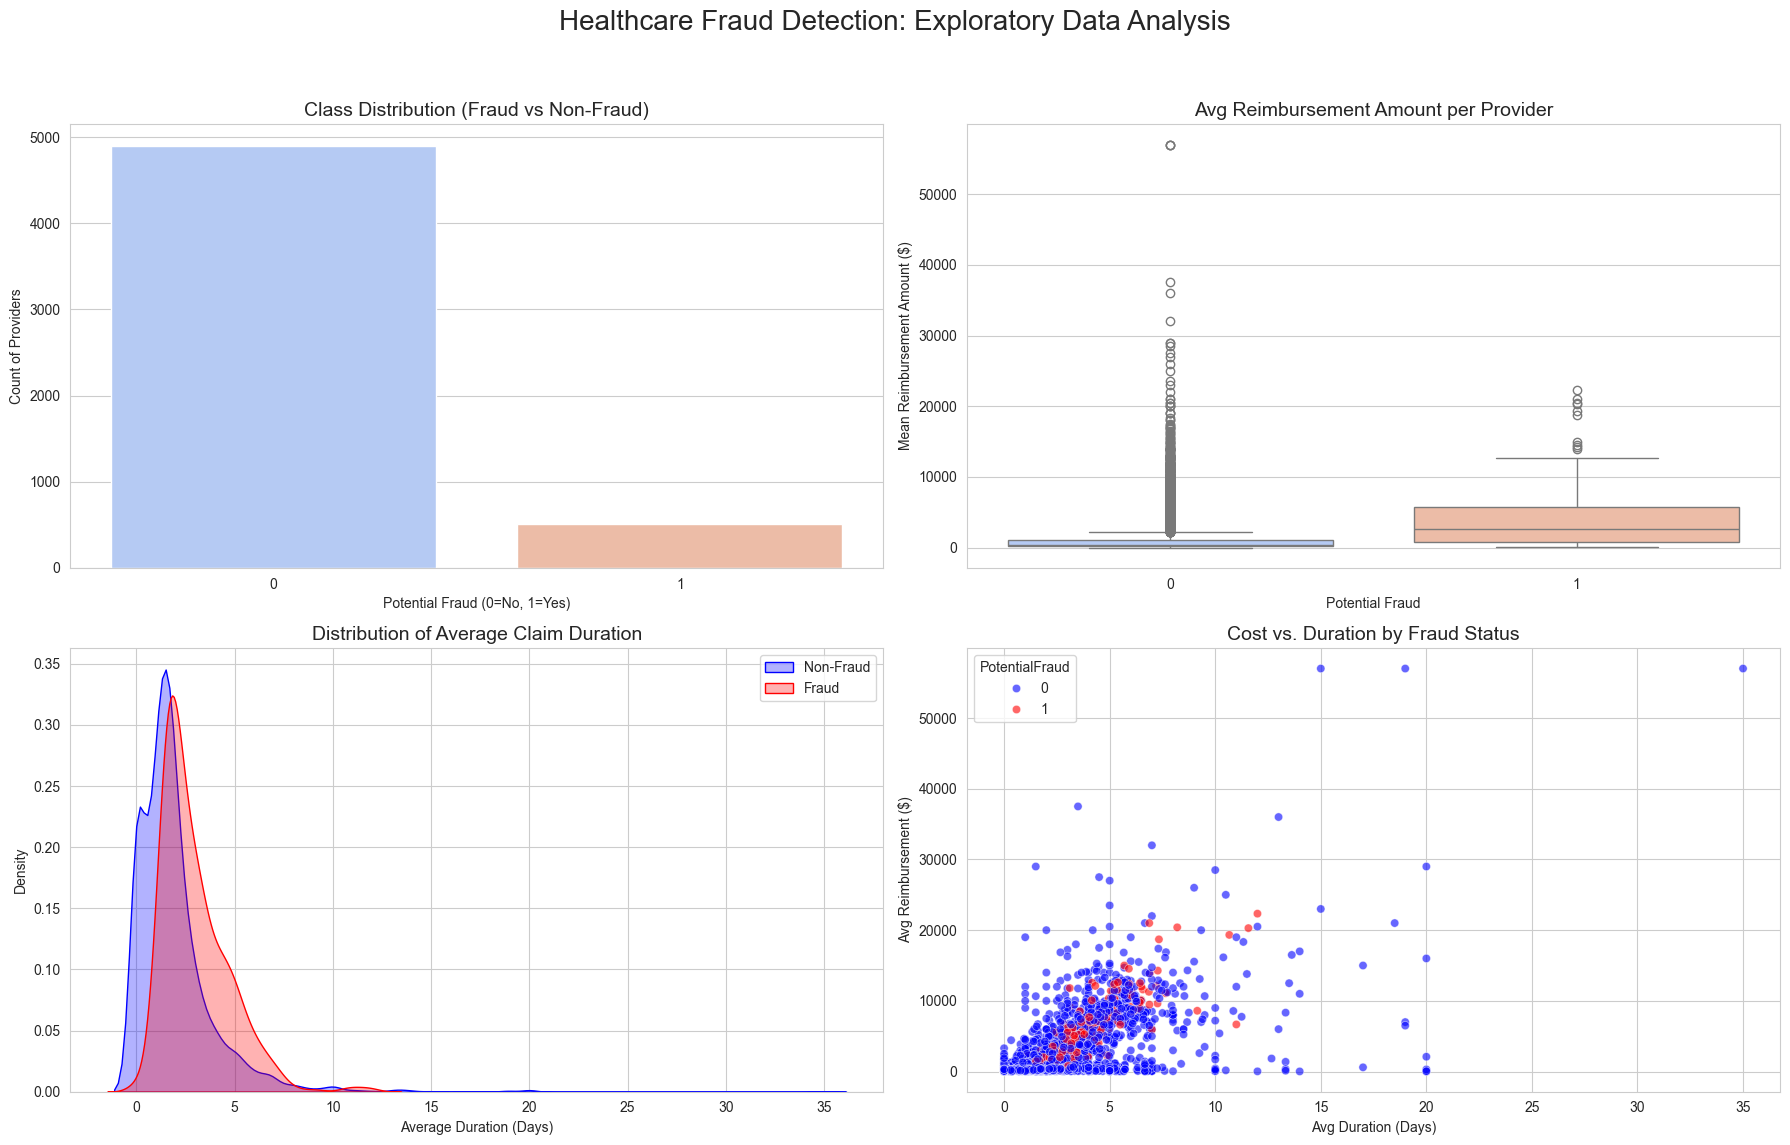

In [10]:

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Healthcare Fraud Detection: Exploratory Data Analysis', fontsize=20)

# --- Plot 1: Class Imbalance (Target Variable) ---
# Visualizing how rare fraud is in the dataset
sns.countplot(ax=axes[0, 0], x='PotentialFraud', data=final_dataset, palette='coolwarm')
axes[0, 0].set_title('Class Distribution (Fraud vs Non-Fraud)', fontsize=14)
axes[0, 0].set_xlabel('Potential Fraud (0=No, 1=Yes)')
axes[0, 0].set_ylabel('Count of Providers')

# --- Plot 2: Financial Impact (Boxplot) ---
# Checking if fraudulent providers claim higher amounts on average
sns.boxplot(ax=axes[0, 1], x='PotentialFraud', y='InscClaimAmtReimbursed_mean', data=final_dataset, palette='coolwarm')
axes[0, 1].set_title('Avg Reimbursement Amount per Provider', fontsize=14)
axes[0, 1].set_xlabel('Potential Fraud')
axes[0, 1].set_ylabel('Mean Reimbursement Amount ($)')

# --- Plot 3: Clinical Duration (KDE Plot) ---
# Checking if fraud involves longer or shorter hospital stays
# We filter by class to plot two overlapping distributions
sns.kdeplot(ax=axes[1, 0], data=final_dataset[final_dataset['PotentialFraud']==0]['ClaimDuration_mean'], 
            label='Non-Fraud', shade=True, color='blue', alpha=0.3)
sns.kdeplot(ax=axes[1, 0], data=final_dataset[final_dataset['PotentialFraud']==1]['ClaimDuration_mean'], 
            label='Fraud', shade=True, color='red', alpha=0.3)
axes[1, 0].set_title('Distribution of Average Claim Duration', fontsize=14)
axes[1, 0].set_xlabel('Average Duration (Days)')
axes[1, 0].legend()

# --- Plot 4: Multivariate Analysis (Scatter Plot) ---
# Looking for clusters: Do fraudsters have both High Cost AND High Duration?
sns.scatterplot(ax=axes[1, 1], x='ClaimDuration_mean', y='InscClaimAmtReimbursed_mean', 
                hue='PotentialFraud', data=final_dataset, palette={0:'blue', 1:'red'}, alpha=0.6)
axes[1, 1].set_title('Cost vs. Duration by Fraud Status', fontsize=14)
axes[1, 1].set_xlabel('Avg Duration (Days)')
axes[1, 1].set_ylabel('Avg Reimbursement ($)')

# Adjust layout to prevent overlapping labels
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

--- Setting up Model Arena ---
--- Training 2 Models ---
Training Logistic Regression...
Training Random Forest...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linea

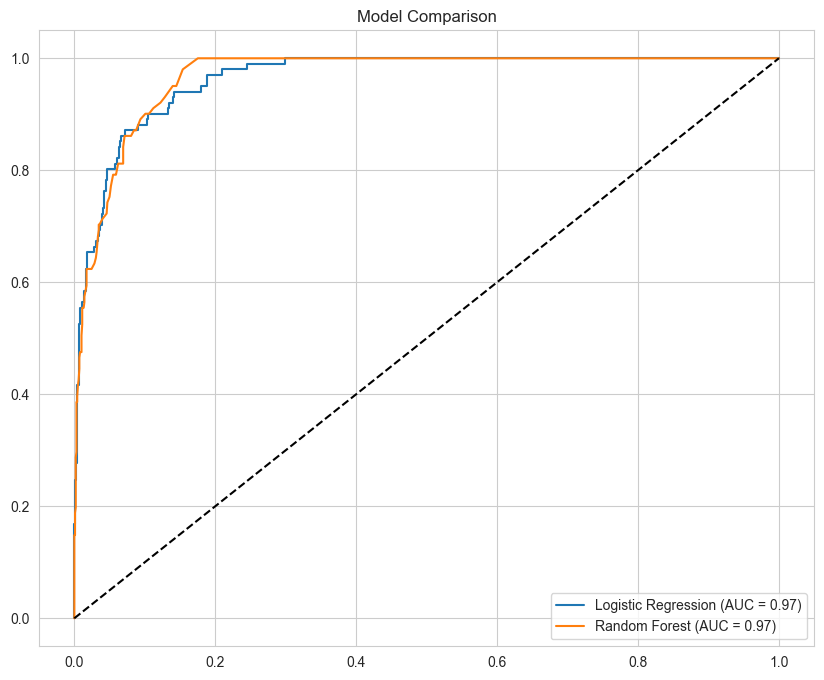


--- 🏆 Model Leaderboard ---
                 Model    Recall  Precision   ROC-AUC
1        Random Forest  0.554455   0.811594  0.968137
0  Logistic Regression  0.900990   0.448276  0.965089


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import joblib

def compare_and_select_model(final_dataset):
    print("--- Setting up Model Arena ---")
    
    # 1. Data Prep
    X = final_dataset.drop(['Provider', 'PotentialFraud'], axis=1)
    y = final_dataset['PotentialFraud']
    
    # 2. Split Data FIRST (Prevents Data Leakage)
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 3. Scaling
    # FIT on Train, TRANSFORM on Test
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_raw) # Learn the math from training data
    X_test = scaler.transform(X_test_raw)       # Apply that math to test data
    
    # Convert back to DataFrame for SHAP (SHAP likes column names)
    X_test_df = pd.DataFrame(X_test, columns=X.columns)

    # 4. Define Models
    models = {
        "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
        "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
    }
    
    results = []
    plt.figure(figsize=(10, 8))
    
    print(f"--- Training {len(models)} Models ---")
    
    # 5. Training Loop
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        
        # Predictions
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        # Metrics
        auc = roc_auc_score(y_test, y_prob)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        results.append({
            "Model": name,
            "Recall": report['1']['recall'],
            "Precision": report['1']['precision'],
            "ROC-AUC": auc
        })
        
        # Plot ROC
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

    # Finalize Plot
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Model Comparison')
    plt.legend()
    plt.show()
    
    leaderboard = pd.DataFrame(results).sort_values(by='ROC-AUC', ascending=False)
    print("\n--- 🏆 Model Leaderboard ---")
    print(leaderboard)
    
    # RETURN EVERYTHING WE NEED
    return leaderboard, models, X_test_df, y_test, scaler

# --- EXECUTION ---
leaderboard, trained_models, X_test, y_test, scaler = compare_and_select_model(final_dataset)

In [16]:
# 1. Select the Random Forest model from the dictionary
selected_model = trained_models["Random Forest"]

# 2. Save the Model and Scaler for Deployment (FastAPI)
joblib.dump(selected_model, 'healthcare_fraud_rf.pkl')
joblib.dump(scaler, 'healthcare_scaler.pkl')

print("✅ Random Forest selected and saved successfully.")

✅ Random Forest selected and saved successfully.


In [21]:
# Save the feature dataset so the API can look up providers
# We drop 'PotentialFraud' because the API doesn't need to know the answer, it predicts it.
final_dataset.drop('PotentialFraud', axis=1).to_csv('provider_features.csv', index=False)

print("Reference data saved to 'provider_features.csv'")

Reference data saved to 'provider_features.csv'
